# Stochastic NN on full sum

In [1]:
import numpy as np
from matplotlib import pylab as plt

In [2]:
import src.operate_datasets    as operate_datasets
import src.model_visualisation as model_visualisation
import src.model_evaluation    as model_evaluation

Welcome to JupyROOT 6.18/00


## Load data

In [3]:
full_X, full_y = operate_datasets.load_dataset('~/snd_data/new_dataset/', 'sum')

X_train, y_train, X_test, y_test = operate_datasets.split_dataset(full_X, full_y)

In [4]:
X_train.shape

(108000,)

In [5]:
X_train = X_train.reshape(-1, 1)
#y_train = y_train.reshape(-1, 1)

X_test = X_test.reshape(-1, 1)
#y_test = y_test.reshape(-1, 1)

In [6]:
min_clip = 0
#X_train, y_train = operate_datasets.clip_dataset(X_train, y_train, min_clip)

## Fit model

In [7]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.distributions import constraints
from torch.optim.lr_scheduler import ReduceLROnPlateau

import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer import SVI, Trace_ELBO, Predictive

In [8]:
X_tens = torch.tensor(X_train).float()
y_tens = torch.tensor(y_train).float()

X_test_tens = torch.tensor(X_test).float()
y_test_tens = torch.tensor(y_test).float()

In [9]:
X_tens.shape

torch.Size([108000, 1])

In [10]:
from pyro.distributions import constraints


class BayesianRegression(PyroModule):
    def __init__(self):
        super().__init__()
        self.linear = PyroModule[nn.Linear](1, 1)
        
        # prior over parameters
        self.linear.weight = PyroSample(dist.Normal(1e-4, 5e-5).expand([1, 1]).to_event(2))
        self.linear.bias   = PyroSample(dist.Normal(1e-1, 5e-2).expand([1]).to_event(1))
        return
    
    def forward(self, x, y=None):
        # energy (from the model)
        mean = self.linear(x).squeeze(-1)
        
        # noise (learnable)
        sigma = pyro.sample("sigma", dist.Uniform(0., 1.)) 
        
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        
        return mean

In [11]:
def model(x, y=None):
    bias   = pyro.sample("bias",   dist.Normal(1e-4, 1e-4))
    weight = pyro.sample("weight", dist.Normal(0.1, 0.1))

    mean = bias + weight * x
    mean = mean.squeeze(-1)
    sigma = pyro.sample("sigma", dist.Uniform(0., 0.1)) 

    with pyro.plate("data", x.shape[0]):
        pyro.sample("obs", dist.Normal(mean, sigma), obs=y)

    return mean


def guide(x, y=None):
    b_loc   = pyro.param("b_loc",   torch.tensor(1e-4), constraint=constraints.positive)
    b_scale = pyro.param("b_scale", torch.tensor(1e-4), constraint=constraints.positive)

    w_loc   = pyro.param("w_loc",   torch.tensor(0.1), constraint=constraints.positive)
    w_scale = pyro.param("w_scale", torch.tensor(0.1), constraint=constraints.positive)

    bias =   pyro.sample("bias",   dist.Normal(b_loc, b_scale))
    weight = pyro.sample("weight", dist.Normal(w_loc, w_scale))

    #sigma_loc = pyro.param('sigma_loc', torch.tensor(5.))
    sigma = pyro.sample("sigma", dist.Normal(0.05, 0.005))

    mean = bias + weight * x
    
    return mean

In [40]:
reg_model = model # BayesianRegression()
reg_guide = guide # AutoDiagonalNormal(model)

num_iterations = 200
initial_lr = 0.1
gamma = 0.1  # final learning rate will be gamma * initial_lr
lrd = gamma ** (1 / num_iterations)

adam = pyro.optim.ClippedAdam({"lr": initial_lr})

#adam = pyro.optim.ClippedAdam({"lr": 1.0, "lrd": 0.5})
svi = SVI(reg_model, reg_guide, adam, loss=Trace_ELBO())

pyro.clear_param_store()
loss_arr = []


for j in range(num_iterations):
    loss = svi.step(X_tens, y_tens)

    loss_arr.append(loss)
        
    if j % 25 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(X_train)))

[iteration 0001] loss: 1181958.9025
[iteration 0026] loss: 51495.4430
[iteration 0051] loss: 2634.8131
[iteration 0076] loss: 163.2191
[iteration 0101] loss: 11.4183
[iteration 0126] loss: 7.7029
[iteration 0151] loss: 15.2639
[iteration 0176] loss: 9.5272


In [41]:
#guide.requires_grad_(False)

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

b_loc tensor(0.0815, grad_fn=<AddBackward0>)
b_scale tensor(0.0007, grad_fn=<AddBackward0>)
w_loc tensor(8.6268e-05, grad_fn=<AddBackward0>)
w_scale tensor(4.2537e-06, grad_fn=<AddBackward0>)


In [42]:
# get predictions on the full dataset for analysis

from pyro.infer import Predictive

def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std":  torch.std(v, 0),
            "5%":   v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%":  v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats

predictive = Predictive(model, guide=guide, num_samples=2000)
samples = predictive(X_train)
pred_summary = summary(samples)

In [57]:
y_pred     = pred_summary['obs']['mean'].detach().cpu().numpy()
y_pred_min = pred_summary['obs']['5%']  .detach().cpu().numpy()
y_pred_max = pred_summary['obs']['95%'] .detach().cpu().numpy()

In [45]:
y_pred

array([0.0888548 , 0.08136383, 0.09198002, ..., 0.08703235, 0.08414321,
       0.08749603])

## Visualise results

In [46]:
X_sum = X_train.sum(axis=1).reshape(-1,1)

In [47]:
y_train = y_train.reshape(-1,1)
y_pred = y_pred.reshape(-1,1)

In [48]:
model_name = 'BNN on full sum'
save_file_prefix = model_name.replace(' ', '-')

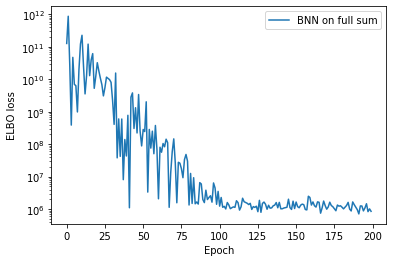

In [49]:
def plot_loss_arrays(loss_dict):
    for key in loss_dict.keys():
        plt.plot(loss_dict[key][0:], label=key)
    
    plt.yscale('log')
    #plt.xscale('log')
    plt.ylabel('ELBO loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    return
    
plot_loss_arrays({model_name : loss_arr})

In [50]:
import matplotlib as mpl

def plot_2d_energy_hist_conf_int(X_full, y_true, y_pred, y_pred_min, y_pred_max, clip, model_name):
    fig, ax = plt.subplots(figsize=(8,6))

    plt.xlim(0,None)
    
    hist = ax.hist2d(X_full[:, 0], y_true[:, 0], 
                     bins=100, norm=mpl.colors.LogNorm(), vmax=150)
    
    plt.xlabel('Total number of hits in the detector')
    plt.ylabel(r'Normalised $E_{true}$')

    plt.axvline(x=clip, c='m', alpha=0.9, label='Min clip ' + str(clip))

    ax.plot(X_full, y_pred_min, 'green', marker='.', linestyle='None', alpha=0.3, label='5% percentile')
    ax.plot(X_full, y_pred_max, 'yellow', marker='.', linestyle='None', alpha=0.3, label='95% percentile')

    ax.plot(X_full, y_pred, 'deeppink', marker='.', linestyle='None', alpha=0.3, label=model_name)

    cbar = fig.colorbar(hist[3], ax=ax)
    cbar.set_label('Number of events')

    plt.legend(loc='lower right')
    plt.show()
    return 

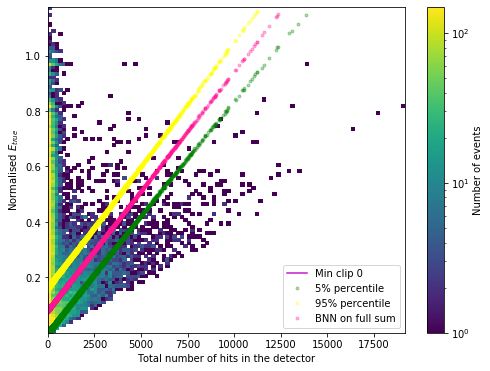

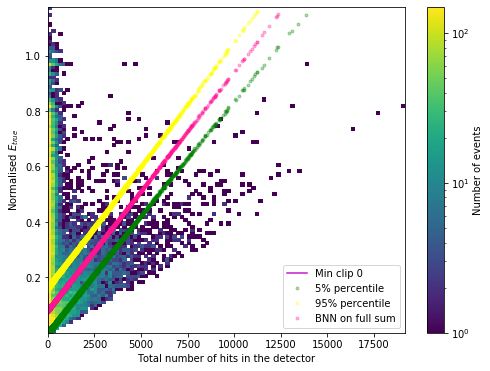

In [51]:
plot_2d_energy_hist_conf_int(X_sum, y_train, y_pred, y_pred_min, y_pred_max, 0, model_name) 

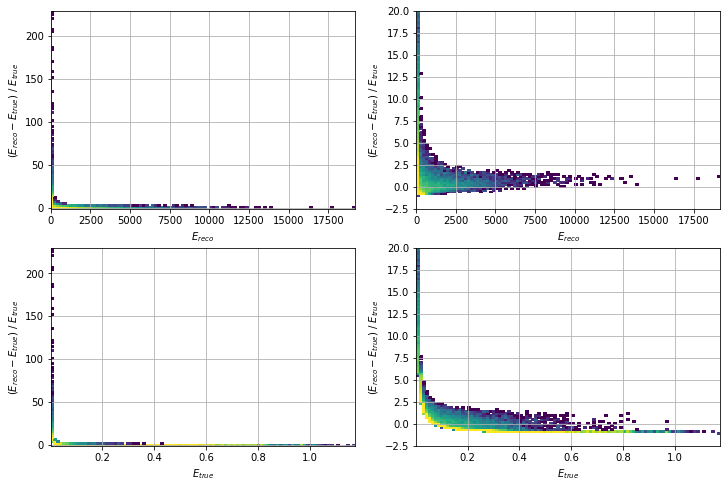

In [52]:
model_visualisation.plot_res_vs_energy(X_sum, y_train, y_pred, vmax=450,
                                       save_file_prefix=save_file_prefix) 

mean   = 3.49675e-01
std    = 3.38527e+00
median = -3.68922e-01


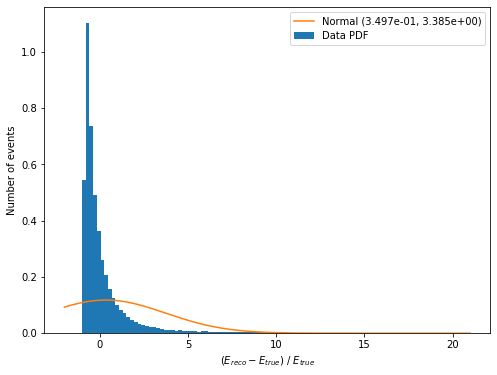

In [53]:
model_visualisation.plot_res_hist_fit(y_train, y_pred, [-1,20],
                                      save_file_prefix=save_file_prefix)

In [54]:
model_evaluation.save_scores(y_train, y_pred, save_file_prefix)

explained_variance_score -0.009649380842140287
max_error 1.0955648506253672
mean_absolute_error 0.13641037843074835
mean_squared_error 0.0433688215886952
median_absolute_error 0.0702427365764222
r2_score -0.3555829073958914


,BNN-on-full-sum
explained_variance_score,-0.009649
max_error,1.095565
mean_absolute_error,0.136410
mean_squared_error,0.043369
median_absolute_error,0.070243
r2_score,-0.355583
avg_resolution,0.349675
std_resolution,3.385274


## Validation

In [55]:
X_sum_test = X_test.sum(axis=1).reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [60]:
samples = predictive(X_test_tens) # , y_test_tens
pred_summary = summary(samples)
y_pred_test = pred_summary['obs']['mean'].detach().cpu().numpy()

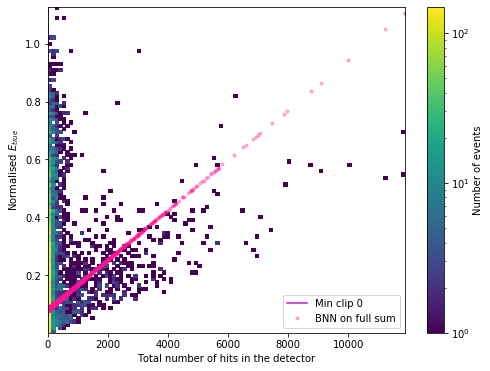

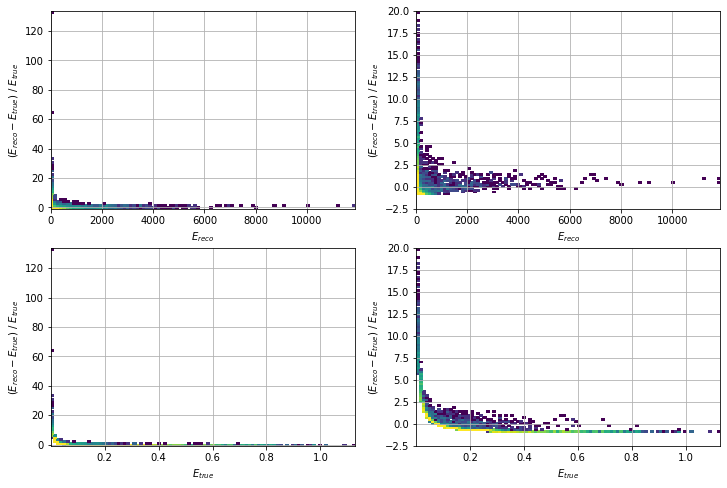

mean   = 2.98509e-01
std    = 2.53624e+00
median = -3.69168e-01


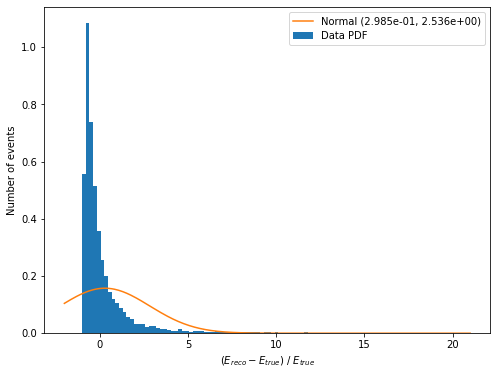

explained_variance_score -0.0015207224722877388
max_error 1.024735220980522
mean_absolute_error 0.13627075853090337
mean_squared_error 0.04315379917423174
median_absolute_error 0.07021833711949624
r2_score -0.35310709734875645


,BNN-on-full-sum
explained_variance_score,-0.001521
max_error,1.024735
mean_absolute_error,0.136271
mean_squared_error,0.043154
median_absolute_error,0.070218
r2_score,-0.353107
avg_resolution,0.298509
std_resolution,2.536236


In [61]:
model_visualisation.plot_2d_energy_hist_clip(X_sum_test, y_test, y_pred_test, min_clip, model_name,
                                             save_file_prefix=save_file_prefix) 

model_visualisation.plot_res_vs_energy(X_sum_test, y_test, y_pred_test, vmax=150,
                                       save_file_prefix=save_file_prefix)  

model_visualisation.plot_res_hist_fit(y_test, y_pred_test, [-1,20],
                                      save_file_prefix=save_file_prefix)

model_evaluation.save_scores(y_test, y_pred_test, save_file_prefix, 
                             folder_path=model_evaluation.TEST_SCORES_DIR)